### This code can let you upload the picture and make prediction for you according to the trained RESNET-34.

In [1]:
import numpy as np
import os, sys, cv2, time
import matplotlib.pyplot as plt
import mxnet as mx
from mxnet import gluon, init, autograd, nd, image
from mxnet.gluon import data as gdata, utils as gutils, nn, loss as gloss
from shutil import copyfile
from mxnet.gluon.data.vision import datasets, transforms
from sklearn.metrics import confusion_matrix
from ipywidgets import interact, IntSlider

In [2]:
pictures_folder = 'New_Picture/'
train_mean = [0.592143940485608, 0.5347022953513785, 0.4981124834847486]
train_std = [0.2880660398985942, 0.2820819880842514, 0.282954693408029]
#extra_validation_dataset = gdata.ArrayDataset(extra_validation_data_x, extra_validation_data_y)

transformer = []
transformer += [gdata.vision.transforms.ToTensor()] # transer the train data from shape (sample, H, W, channel) to (sample, channel, H, W) and rescale to between 0 and 1 
transformer += [gdata.vision.transforms.Normalize(train_mean, train_std)]
transformer = gdata.vision.transforms.Compose(transformer)
#validation_iter = gdata.DataLoader(extra_validation_dataset.transform_first(extra_transformer), batch_size = 64, shuffle=False, num_workers=4)

In [3]:
def try_gpu():
    """If GPU is available, return mx.gpu(0); else return mx.cpu()."""
    try:
        ctx = mx.gpu()
        _ = nd.array([0], ctx=ctx)
    except mx.base.MXNetError:
        ctx = mx.cpu()
    return ctx

In [4]:
ctx = try_gpu()

In [5]:
class Residual(nn.Block):
    def __init__(self, num_channels, use_1x1conv=False, strides=1, **kwargs):
        super(Residual, self).__init__(**kwargs) 
        self.conv1 = nn.Conv2D(num_channels, kernel_size=3, padding=1, strides=strides) # this layer down-sampling the input
        self.conv2 = nn.Conv2D(num_channels, kernel_size=3, padding=1)  # the layer doesn't down-sampling the input
        
        if use_1x1conv:
            self.conv3 = nn.Conv2D(num_channels, kernel_size=1, strides=strides)
            # to match the dimension of feature map of conv1 + conv2, the strides must be set to be identicla to conv 1
        else: 
            self.conv3 = None 
            
        self.bn1 = nn.BatchNorm() 
        self.bn2 = nn.BatchNorm()
        
    def forward(self, X):
        Y = nd.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y)) 
        if self.conv3:
            X = self.conv3(X)

        return nd.relu(Y + X)
    
def resnet_block(num_channels, num_residuals, first_block=False): 
    blk = nn.Sequential() 
    for i in range(num_residuals): 
        if i == 0 and not first_block:
            #net.add(Residual(num_channels, use_1x1conv=True, strides=2))
            blk.add(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            #net.add(Residual(num_channels, strides=1))
            blk.add(Residual(num_channels, strides=1))
    return blk

In [6]:
num_of_output_channels = [64, 128, 256, 512]
num_residuals = [3, 4, 6, 3]

net_RESNET = nn.Sequential() 
net_RESNET.add(nn.Conv2D(64, kernel_size=7, strides=2, padding=3),
        nn.BatchNorm(), 
        nn.Activation('relu'),
        nn.MaxPool2D(pool_size=3, strides=2, padding=1))

for i, num in enumerate(num_of_output_channels):
    if i==0:
        net_RESNET.add(resnet_block(num, num_residuals[i], first_block=True))
    else:
        net_RESNET.add(resnet_block(num, num_residuals[i]))
    net_RESNET.add(nn.Dropout(0.1))

net_RESNET.add(nn.GlobalAvgPool2D(), nn.Dense(6))

In [8]:
net_RESNET.load_parameters('Weight_Train_Test_Mixed/RESNET34_DROPOUT_train_data_transposed_2.params', ctx= ctx)

### Load the Picture

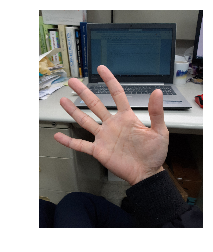

(4608, 3456, 3)

In [9]:
file_name = '5_IMG_12356.jpg'
pic = cv2.imread(pictures_folder+file_name)
pic_plt = pic[:,:,::-1]
plt.imshow(pic_plt)
plt.axis('off')
plt.show()
pic_plt.shape

### Resize and Crop the Picture

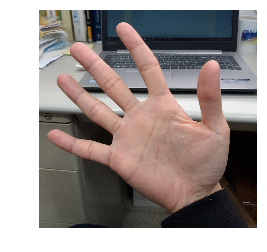

In [10]:
shift_h = 1000
shift_w = 200
size = 2900
pic_plt_crop = pic_plt[shift_h:shift_h+size, shift_w:shift_w+size,:]
pic_plt_crop.shape

plt.imshow(pic_plt_crop)
plt.axis('off')
plt.show()

In [11]:
pic = cv2.resize(pic_plt_crop[:,:,::-1], (256,256), interpolation=cv2.INTER_AREA)
cv2.imwrite(pictures_folder+file_name, pic)

True

### Use image to Load Picture and Make Prediction

In [12]:
test_image = image.imread(pictures_folder+file_name)

In [13]:
test_pic = nd.zeros((1,256,256,3))
test_pic[0] = test_image.copy()
label = file_name.split('_',1)[0]
if label == '0':
    y_correct = 0
elif label == '1':
    y_correct = 1
elif label == '2':
    y_correct = 2
elif label == '3':
    y_correct = 3
elif label == '4':
    y_correct = 4
elif label == '5':
    y_correct = 5
else:
    raise RuntimeError('Please name the picture correctly!')

test_pic = gdata.ArrayDataset(test_pic, np.array([y_correct]))
test_pic = gdata.DataLoader(test_pic.transform_first(transformer), batch_size = 1, shuffle=False, num_workers=4)

Prediction is: 5
Label is: 5


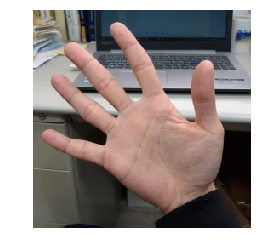

In [14]:
for X,y in test_pic:
    print('Prediction is:',net_RESNET(X.as_in_context(ctx))[0].asnumpy().argmax())
    print('Label is: %d'%y.asscalar())
    break
plt.imshow(test_image.asnumpy().astype(np.uint8))
plt.axis('off')
plt.show()